In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)

import warnings
warnings.filterwarnings("ignore")

## Toy case models and datasets

In [2]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to match model output shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape y_test to match model output shape

In [3]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

### Simple training loop 

In [4]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 108.9392
Epoch [20/100], Loss: 43.4876
Epoch [30/100], Loss: 24.4725
Epoch [40/100], Loss: 18.0850
Epoch [50/100], Loss: 14.4142
Epoch [60/100], Loss: 12.0501
Epoch [70/100], Loss: 10.4739
Epoch [80/100], Loss: 9.5392
Epoch [90/100], Loss: 8.7902
Epoch [100/100], Loss: 8.1955
Test Loss: 12.1529


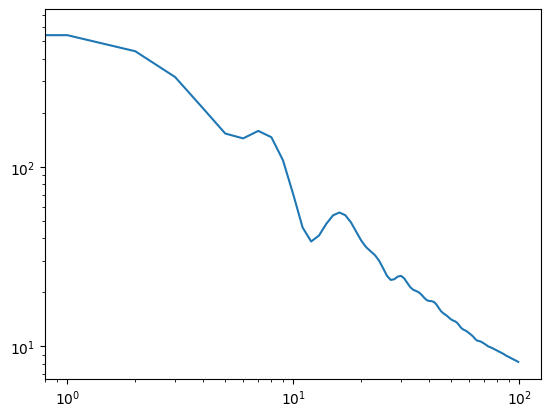

In [5]:
plt.loglog(train_losses)

# SCALTRA implementation

In [242]:
class SCALTRA(nn.Module):
    def __init__(self, model, epochs, 
                 loss_criterion,
                 beta = 0.9, tau = 100, gamma = 0.9):
        super().__init__()

        # Initialization of the learnable parameters
        #self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)

        self.tau = tau
        self.gamma = gamma
        self.beta = beta

        self.B = []
        self.momentum = []

        for _, p in model.named_parameters():
            self.B.append(nn.Parameter(torch.randn(p.shape), requires_grad = True))
            self.momentum.append(torch.zeros_like(p))

        self.params = nn.ParameterList(self.B)

        # Some more initialization

        self.loss_criterion = loss_criterion
        self.meta_optimizer = torch.optim.Adam(params=self.parameters(), lr=5e-1)
        self.epochs = epochs


    def forward(self, model, X, y):
        train_losses = []

        for _ in tqdm(range(self.epochs)):

            #new_params = []
            part_grad = []
            for i, (_, p) in enumerate(model.named_parameters()):

                # Local optimization step
                if len(p.shape) == 1:
                    H = 1/(self.B[i]**2 + self.tau*torch.ones(self.B[i].shape[0])) * self.momentum[i]
                    #new_params.append(nn.Parameter(p - 1/(self.B[i]**2 + self.tau*torch.ones(self.B[i].shape[0])) * self.momentum[i], requires_grad = True))

                    part_grad.append(-self.gamma*(torch.autograd.grad(H,
                                                                      self.B[i],
                                                                      torch.ones_like(H),
                                                                      retain_graph=True)[0]))

                else:
                    H = torch.linalg.inv(torch.matmul(self.B[i],torch.transpose(self.B[i],0,1)) + self.tau*torch.eye(self.B[i].shape[0])) @ self.momentum[i]
                    #new_params.append(nn.Parameter(p - torch.linalg.inv(torch.outer(self.B[i],self.B[i]) + self.tau*torch.eye(self.B[i].shape[0])) @ self.momentum[i], requires_grad = True))
                    part_grad.append(-self.gamma*(torch.autograd.grad(H,
                                                                      self.B[i],
                                                                      torch.ones_like(H),
                                                                      retain_graph=True)[0]))

                with torch.no_grad():

                    # Convex smoothing
                    p.copy_(p - H)
                

            #new_params = nn.ParameterList(new_params)

            loss = self.loss_criterion(model(X), y)

            # Zero gradients for optimizer parameters
            self.zero_grad()

            # Backward phase
            loss.backward()

            for i, (p, v) in enumerate(zip(model.parameters(), self.parameters())):
                
                v.grad = part_grad[i] * p.grad
                
                '''
                v.grad = torch.autograd.grad(inputs = new_params[i],
                                             outputs = v,
                                             grad_outputs=torch.ones_like(v),
                                             allow_unused=True)[0] @ p.grad
                '''
            # Update optimizer parameters
            self.meta_optimizer.step()  

            # Update momentum
            for i, (_, p) in enumerate(model.named_parameters()):
                self.momentum[i] = self.beta * self.momentum[i] + (1 - self.beta) * p.grad

            train_losses.append(loss.detach().numpy())

            self.gamma *= 0.99

        return train_losses

In [243]:
optimizer.B[1]

Parameter containing:
tensor([-1.3518,  0.9641, -0.1396, -1.6085,  0.2164,  0.0938,  1.8169,  0.6789,
         0.6860,  1.0652, -1.0679,  0.9290,  0.6003, -1.1453, -0.5814,  0.1690,
         0.4609,  0.7734, -1.0847, -0.6201,  0.6459, -1.6293, -2.0563, -1.0072,
        -1.6182,  0.9422,  0.8653,  0.8508, -0.1489,  0.2925],
       requires_grad=True)

In [248]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

criterion = nn.MSELoss()
optimizer = SCALTRA(model, 8, criterion)

In [249]:
L = optimizer.forward(model, X_train_tensor, y_train_tensor)

100%|██████████| 8/8 [00:00<00:00, 363.60it/s]


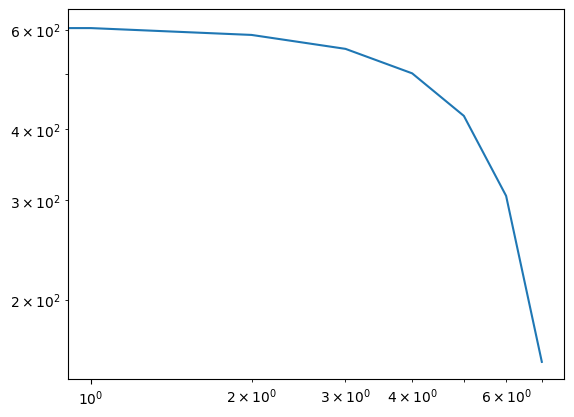

In [250]:
plt.loglog(L)

In [251]:
L

[array(609.26746, dtype=float32),
 array(603.7995, dtype=float32),
 array(587.2437, dtype=float32),
 array(554.8792, dtype=float32),
 array(502.3015, dtype=float32),
 array(422.46176, dtype=float32),
 array(305.13135, dtype=float32),
 array(155.31323, dtype=float32)]